# 02 · Visualize YOLO Samples

Plot random PCB defect samples with their YOLOv8 bounding boxes to sanity-check the converted annotations and splits.


In [1]:
from pathlib import Path
import random

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

DATA_ROOT = Path("../PCB_DATASET").resolve()
YOLO_ROOT = DATA_ROOT / "yolo_dataset"
CLASS_NAMES = [
    "Missing_hole",
    "Mouse_bite",
    "Open_circuit",
    "Short",
    "Spur",
    "Spurious_copper",
]


In [2]:
def read_label(label_path):
    rows = []
    for line in Path(label_path).read_text().strip().splitlines():
        cls, cx, cy, w, h = map(float, line.split())
        rows.append({"class_id": int(cls), "cx": cx, "cy": cy, "w": w, "h": h})
    return pd.DataFrame(rows)


def denormalize(box_df, width, height):
    box_df = box_df.copy()
    box_df["xmin"] = (box_df["cx"] - box_df["w"] / 2) * width
    box_df["xmax"] = (box_df["cx"] + box_df["w"] / 2) * width
    box_df["ymin"] = (box_df["cy"] - box_df["h"] / 2) * height
    box_df["ymax"] = (box_df["cy"] + box_df["h"] / 2) * height
    box_df["class_name"] = box_df["class_id"].map(dict(enumerate(CLASS_NAMES)))
    return box_df


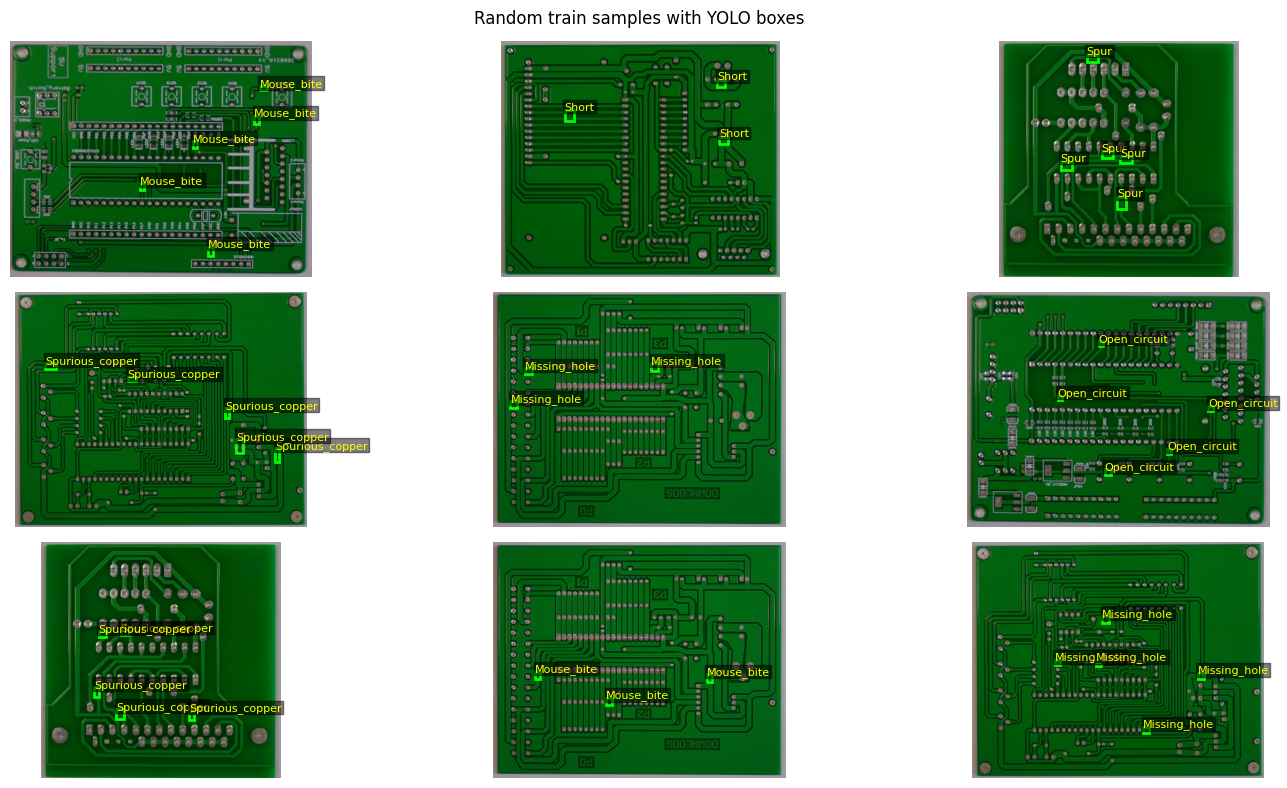

In [3]:
def plot_sample(image_path, boxes_df, ax):
    img = Image.open(image_path)
    ax.imshow(img)
    for _, row in boxes_df.iterrows():
        rect = plt.Rectangle((row["xmin"], row["ymin"]), row["xmax"] - row["xmin"], row["ymax"] - row["ymin"],
                             fill=False, color="lime", linewidth=2)
        ax.add_patch(rect)
        ax.text(row["xmin"], row["ymin"] - 5, row["class_name"], color="yellow", fontsize=8,
                bbox=dict(facecolor="black", alpha=0.5, pad=1))
    ax.axis("off")


split = "train"
image_dir = YOLO_ROOT / "images" / split
label_dir = YOLO_ROOT / "labels" / split
samples = random.sample(list(image_dir.glob("*.jpg")), k=9)

fig, axes = plt.subplots(3, 3, figsize=(15, 8))
for ax, img_path in zip(axes.flat, samples):
    label_path = label_dir / (img_path.stem + ".txt")
    boxes = denormalize(read_label(label_path), *Image.open(img_path).size)
    plot_sample(img_path, boxes, ax)
fig.suptitle(f"Random {split} samples with YOLO boxes")
plt.tight_layout()
plt.show()
